In [8]:
%matplotlib inline
import importlib
from pytorch_utils_oh_2 import *
import IPython

In [9]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [10]:
MODEL_SAVE_PATH = 'whole_gen_13_2_only_chars_smaller'

In [11]:
import pytorch_utils_oh_2; importlib.reload(pytorch_utils_oh_2); from pytorch_utils_oh_2 import *;

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


# Data loading

In [12]:
# all_data = pickle.load(open("data/en_train_fixed_4_sentences.pkl", "rb" ))
all_data = pickle.load(open("data/en_train_fixed_5_manual.pkl", "rb" ))
# all_data_sentence_index = all_data.set_index('sentence_id')

In [13]:
sample_data = all_data.copy()
sample_data = sample_data[sample_data['class'] != 'NOT_CHANGED']
sample_data = sample_data[sample_data['class'] != 'MANUAL']
sample_data = sample_data[sample_data['before'].str.len() > 0]
sample_data = pd.concat([sample_data, all_data[all_data['class_org'] == 'PLAIN'].sample(1000000)])
# sample_data = sample_data[sample_data['class'] != 'ELECTRONIC']
sample_data = sample_data.reset_index(drop=True)
print("Data rows: {},  (dropped rows: {})".format(len(sample_data), len(all_data)-len(sample_data)))
del(all_data)

Data rows: 1654328,  (dropped rows: 8263864)


In [14]:
sample_data.sample(4)

,sentence_id,token_id,class,before,after,class_org,a_word_ind,sentence
1021305,201966,9,NOT_CHANGED,before,before,PLAIN,NaN,the match was reduced to 35 overs per side <SA...
999788,317477,13,NOT_CHANGED,frequently,frequently,PLAIN,NaN,he does state that quarrels between palace wom...
1137756,67477,4,NOT_CHANGED,on,on,PLAIN,NaN,archived from the original <SAMPLE> august 10 ...
835873,266101,0,NOT_CHANGED,Wurtz,Wurtz,PLAIN,NaN,"<SAMPLE> received no academic studies , but ha..."


In [16]:
categories_all = sorted(sample_data["class"].unique())
print(categories_all)
print(len(categories_all))
categories_index = dict((c, i) for i, c in enumerate(categories_all))

['ELECTRONIC', 'LETTERS', 'NOT_CHANGED', 'NUMBERS', 'PLAIN', 'VERBATIM']
6


In [17]:
sample_data.sample(2)

,sentence_id,token_id,class,before,after,class_org,a_word_ind,sentence
235664,270703,5,LETTERS,Uson,u s o n,LETTERS,"[43, 17, 25, 29, 0]","matthews , lynn d . ; <SAMPLE> , juan m . ( 20..."
659392,170845,18,NOT_CHANGED,sur,sur,PLAIN,NaN,champigny is a railway station in the commune ...


In [18]:
sample_data = sample_data[sample_data['before'].str.len() > 0]

In [19]:
sample_data[sample_data['after'].str.len() < 1]

,sentence_id,token_id,class,before,after,class_org,a_word_ind,sentence


### Utils stuff

In [20]:
chars_normal, chars_normal_index = load_characters_pkl('data/en_features/chars_normal.pkl')
print(''.join(chars_normal))

<SOS><EOS>☒ !"#$%&'(),-./0123456789:;ABCDEFGHIJKLMNOPQRSTUVWXYZ_abcdefghijklmnopqrstuvwxyz~£¥ª²³µº¼½¾éɒʻˈΩμ—€⅓⅔⅛


In [21]:
chars_after = sorted(list(set(''.join(list(sample_data['after'].unique())).lower())))
chars_after = [SOS_TOKEN, EOS_TOKEN, UNKNOWN_CHAR] + chars_after
chars_after_index = dict((c, i) for i, c in enumerate(chars_after))
print(''.join(chars_after))

<SOS><EOS>☒ 'abcdefghijklmnopqrstuvwxyzé


chars_after, chars_after_index = load_characters_pkl('data/en_features/chars_after_1.pkl')
print(''.join(chars_after))

In [22]:
wv_vecs, wv_words, wv_idx = load_glove('/home/ohu/koodi/data/glove_wordvec/glove.6B.50d.txt')

### After words handling

In [23]:
sos_tensor = torch.zeros(1, 1, len(chars_after_index))
sos_tensor[0, 0, chars_after_index[SOS_TOKEN]] = 1
sos_tensor.size()

torch.Size([1, 1, 32])

### More balanced sample

In [24]:
import collections

balanced_data_classes_select = list(sample_data.groupby('class'))

balanced_data_accessed_counter = 0 
balanced_data_randomize_freq = False
balanced_data_length = 0

last_samples = collections.deque(maxlen=100)
balanced_data_last_sample = last_samples

def balanced_data_randomize_org(max_len=30000):
    global balanced_data, balanced_data_length, balanced_data_accessed_counter, balanced_data_randomize_freq
    balanced_data = pd.concat([v.sample(min(max_len, len(v))) for k, v in balanced_data_classes_select])
    balanced_data = pd.concat([balanced_data, sample_data[sample_data['class']=='NOT_CHANGED'].sample(int(max_len*2))])
    balanced_data_length = len(balanced_data)
    balanced_data_randomize_freq = balanced_data_length * 0.2
    balanced_data_accessed_counter = 0
balanced_data_randomize = balanced_data_randomize_org

def balanced_data_sample_row():
    global balanced_data_accessed_counter
    global balanced_data_last_sample
    balanced_data_accessed_counter += 1
    if balanced_data_randomize_freq and balanced_data_accessed_counter > balanced_data_randomize_freq:
        balanced_data_randomize()
        
    sample = balanced_data.iloc[random.randint(1, balanced_data_length-1)]
    last_samples.append(sample)
    balanced_data_last_sample = sample
    return sample
    
balanced_data_randomize()

In [25]:
#all_data.groupby('class')['class'].count()
#sample_data.groupby('class')['class'].count()
balanced_data.groupby('class')['class'].count()

class
ELECTRONIC      4964
LETTERS        30000
NOT_CHANGED    90000
NUMBERS        30000
PLAIN          30000
VERBATIM       11741
Name: class, dtype: int64

In [26]:
balanced_data_sample_row()

sentence_id                                               392314
token_id                                                      17
class                                                 ELECTRONIC
before         https://diva.sfsu.edu/collections/sfbatv/bundl...
after          h t t p s colon slash slash d i v a dot s f s ...
class_org                                             ELECTRONIC
a_word_ind     [45, 30, 30, 24, 17, 129, 101, 101, 26, 31, 54...
sentence       watch the full 60 minute version of this 1973 ...
Name: 340541, dtype: object

In [31]:
last_samples[-1]

sentence_id                                               392314
token_id                                                      17
class                                                 ELECTRONIC
before         https://diva.sfsu.edu/collections/sfbatv/bundl...
after          h t t p s colon slash slash d i v a dot s f s ...
class_org                                             ELECTRONIC
a_word_ind     [45, 30, 30, 24, 17, 129, 101, 101, 26, 31, 54...
sentence       watch the full 60 minute version of this 1973 ...
Name: 340541, dtype: object

### Samples

In [32]:
def get_random_sample():
    sample_row = balanced_data_sample_row()   
    return sample_row['before'], sample_row['after'].lower(), sample_row['class'], sample_row['sentence'].split(' ')
            
def tmp():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    print(s_class, ':', s_bef, '->', s_aft)
    print(s_sentence)
    print(string_to_tensor(s_bef, chars_normal_index).shape)
tmp()

PLAIN : - -> to
['505', '<SAMPLE>', '510', 'fritz', 'engbarth', '(', '2009', ')', '.']
torch.Size([1, 2, 104])


In [33]:
%%time
get_random_sample()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 281 µs


('Department',
 'department',
 'NOT_CHANGED',
 ['university', 'of', 'memphis', 'athletic', '<SAMPLE>', '.'])

# Model functions

In [34]:
use_cuda = True

In [35]:
MAX_ATTENTION_LENGTH = 30

In [36]:
tmp = sample_data[sample_data['before'].str.len()>MAX_ATTENTION_LENGTH]
len(tmp)
tmp.sample(2)
# tmp[~tmp['before'].str.contains('/')].sample(2)

754

,sentence_id,token_id,class,before,after,class_org,a_word_ind,sentence
402909,464991,1,ELECTRONIC,StiftungSteffi-LineKino.deWistrich,s t i f t u n g s t e f f i d a s h l i n e k ...,ELECTRONIC,"[17, 30, 31, 37, 30, 43, 29, 53, 17, 30, 28, 3...","murnau <SAMPLE> , robert s . 1982 ."
641126,732304,2,ELECTRONIC,http://www.crnns.ca/documents/ProfessionalBoun...,h t t p colon slash slash w w w dot c r n n s ...,ELECTRONIC,"[45, 30, 30, 24, 129, 101, 101, 52, 52, 52, 74...","retrieved from <SAMPLE> , m . , & blazer riley..."


### Encoder

In [37]:
class EncoderRNN(nn.Module):
    def __init__(self, words_input_size, chars_input_size, words_hidden_size, chars_hidden_size,
                 words_layers=1, chars_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.words_layers = words_layers
        self.chars_layers = chars_layers
        self.words_hidden_size = words_hidden_size
        self.chars_hidden_size = chars_hidden_size
        self.hidden_size = words_hidden_size + chars_hidden_size

        self.rnn_words = nn.GRU(words_input_size, words_hidden_size // 2, words_layers,
                                 batch_first=True, bidirectional=True)

        self.rnn_chars = nn.GRU(chars_input_size, chars_hidden_size // 2, chars_layers,
                                 batch_first=True, bidirectional=True)
        
    def forward(self, word_vectors, string_tensor, hidden = None, init_hidden = True):
        if init_hidden:
            hidden_words, hidden_chars = self.init_hidden()
        
        all_outputs_words, hidden_words = self.rnn_words(word_vectors, hidden_words)
        output_words = hidden_words.view(1, -1)
        
        all_outputs_chars, hidden_chars = self.rnn_chars(string_tensor, hidden_chars)
        output_chars = hidden_chars.view(1, -1)
        
        #hidden_states_cat = Variable(torch.zeros(MAX_ATTENTION_LENGTH, self.hidden_size)).cuda()
        #for ei in range(min(MAX_ATTENTION_LENGTH, len(string_tensor[0]))):
        #    hidden_states_cat[ei] = torch.cat((output_words, all_outputs_chars[0, ei].view(1,-1)), 1)

        all_outputs_chars_padded = Variable(torch.zeros(MAX_ATTENTION_LENGTH, self.chars_hidden_size)).cuda()
        att_length = min(len(all_outputs_chars[0]), MAX_ATTENTION_LENGTH-1)
        all_outputs_chars_padded[0:att_length] = all_outputs_chars[0][0:att_length]
        
        output = torch.cat((output_words, output_chars), 1)

        #output = torch.cat((output_words, output_chars), 1)
        
        #return output, all_outputs_chars
        return output, all_outputs_chars_padded

    def init_hidden(self):
        var1 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var2 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        
        var1 = var1.cuda(); var2 = var2.cuda()
        return (var1, var2)
    
    
encoder_rnn = EncoderRNN(words_input_size=wv_vecs.shape[-1], chars_input_size=len(chars_normal),
                         words_hidden_size=128, chars_hidden_size=256,
                         words_layers=1, chars_layers=1).cuda()
encoder_rnn

EncoderRNN (
  (rnn_words): GRU(50, 64, batch_first=True, bidirectional=True)
  (rnn_chars): GRU(104, 128, batch_first=True, bidirectional=True)
)

In [38]:
def test_encoder_single_sample():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    #s_bef, s_aft, s_class, s_sentence = get_random_sample(True)
    print(s_bef)
    
    words_t = Variable(words_to_word_vectors_tensor(s_sentence, wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    return encoder_rnn(words_t, string_t), s_bef
    
(tmp_encoder_output, tmp_encoder_outputs), tmp = test_encoder_single_sample()
tmp
tmp_encoder_output.size()
tmp_encoder_outputs.size()

S.


'S.'

torch.Size([1, 384])

torch.Size([30, 256])

### Decoder

In [39]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, chars_encoded_size,
                 n_layers=1, dropout_p=0.1, max_length=MAX_ATTENTION_LENGTH):
        super(DecoderRNN, self).__init__()
        
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.max_length = max_length
        
        self.emb_lin = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.attn = nn.Linear(self.hidden_size+self.hidden_size, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size+chars_encoded_size, self.hidden_size)
        
        #self.module_attn = torch.nn.ModuleList([self.emb_lin, self.dropout, self.attn, self.attn_combine])
        
        
        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers, batch_first=True, bidirectional=False)
        self.lin_out = nn.Linear(hidden_size, input_size)
        
        #self.module_rnn = torch.nn.ModuleList([self.rnn, self.lin_out])

    def forward(self, last_input, hidden, encoder_outputs):
        embedded = self.emb_lin(last_input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        embedded = embedded[0]
                
        attn_weights = F.softmax(self.attn(torch.cat((embedded, hidden), 1)))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        #return embedded, attn_applied
        
        rnn_input = torch.cat((embedded, attn_applied[0]), 1)
        rnn_input = self.attn_combine(rnn_input).unsqueeze(0)
        rnn_input = F.relu(rnn_input)
    
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        output = F.log_softmax(self.lin_out(output[0]))
        
        return output, hidden[0], attn_weights
    
    def init_rest_hidden(self, input_var):
        if self.n_layers > 1:
            hid_var = Variable(torch.zeros(self.n_layers - 1, 1, self.hidden_size)).cuda()
            res = torch.cat((input_var, hid_var), 0)
            return res
        else:
            return input_var
        
    def mods_split(self):
        mods = list(decoder_rnn.modules())[1:]
        for gru_index, mod in enumerate(mods):
            #print(mod)
            if type(mod) == torch.nn.modules.rnn.GRU:
                break
        return mods[:gru_index], mods[gru_index:]
        
    def mods_attn(self):
        return self.mods_split()[0]
        
    def mods_gru(self):
        return self.mods_split()[1]

decoder_rnn = DecoderRNN(input_size=len(chars_after), hidden_size=tmp_encoder_output.size()[1],
                         chars_encoded_size=tmp_encoder_outputs.size()[1], n_layers=1)
decoder_rnn = decoder_rnn.cuda()
decoder_rnn

tmp = decoder_rnn(Variable(sos_tensor).cuda(), tmp_encoder_output, tmp_encoder_outputs)
#tmp
[v.size() for v in tmp]

DecoderRNN (
  (emb_lin): Linear (32 -> 384)
  (dropout): Dropout (p = 0.1)
  (attn): Linear (768 -> 30)
  (attn_combine): Linear (640 -> 384)
  (rnn): GRU(384, 384, batch_first=True)
  (lin_out): Linear (384 -> 32)
)

[torch.Size([1, 32]), torch.Size([1, 384]), torch.Size([1, 30])]

In [40]:
tmp = [{'params': mod.parameters(), 'lr': 3} for mod in decoder_rnn.mods_attn()]
tmp += [{'params': mod.parameters()} for mod in decoder_rnn.mods_gru()]
tmp.append(
    {'params': encoder_rnn.parameters()}
)
tmp

[{'lr': 3, 'params': <generator object Module.parameters at 0x7effaabfe2b0>},
 {'lr': 3, 'params': <generator object Module.parameters at 0x7effaabfe468>},
 {'lr': 3, 'params': <generator object Module.parameters at 0x7effaabfe5c8>},
 {'lr': 3, 'params': <generator object Module.parameters at 0x7effaabfe620>},
 {'params': <generator object Module.parameters at 0x7effaab3d678>},
 {'params': <generator object Module.parameters at 0x7effaab3d6d0>},
 {'params': <generator object Module.parameters at 0x7effaab3d410>}]

# Training etc

### Accuracy

In [42]:
def test_model_single_sample(model=None, return_more=False, sample=False):
    decoder_rnn.eval()
    encoder_rnn.eval()
    global encoder_output, encoder_outputs, decoded_output, char_index
    
    if not sample:
        sample = get_random_sample()
    s_bef, s_aft, s_class, s_sentence = sample
        
    words_t = Variable(words_to_word_vectors_tensor(s_sentence, wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    encoder_output, encoder_outputs = encoder_rnn(words_t, string_t)
    
    decoder_input = Variable(sos_tensor).cuda()
    decoder_hidden = encoder_output
    
    decoded_output = []
    decoder_attns_arr = []
    max_length = 50
    for _ in range(max_length):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)
        decoder_attns_arr.append(decoder_attns)
        #return decoder_output

        topv, topi = decoder_output.data.topk(1)
        char_index = topi[0][0]
        char = chars_after[char_index] # Use own prediction as next input
                
        if char == EOS_TOKEN:
            break

        decoded_output.append(char)
                
        decoder_input = torch.zeros(1, 1, len(chars_after_index))
        decoder_input[0, 0, char_index] = 1
        decoder_input = Variable(decoder_input).cuda()
    
    output = ''.join(decoded_output)
    sample_target = s_aft
    
    decoder_rnn.train()
    encoder_rnn.train()
    
    if return_more:
        return output, decoded_output, decoder_attns_arr, sample
    
    return output, output, sample_target, sample
    
tmp = test_model_single_sample(None)
tmp

('vvvrhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh',
 'vvvrhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh',
 'peptides',
 ('peptides',
  'peptides',
  'NOT_CHANGED',
  ['"',
   'phytochelatins',
   ',',
   'the',
   'heavy',
   'metal',
   'binding',
   '<SAMPLE>',
   'of',
   'plants',
   ',',
   'are',
   'synthesized',
   'from',
   'glutathione',
   'by',
   'a',
   'specific',
   'gamma',
   'glutamylcysteine',
   'dipeptidyl',
   'transpeptidase',
   '(',
   'phytochelatin',
   'synthase',
   ')',
   '"',
   '.']))

In [43]:
def print_local_wrong_predictions(max_results=10):
    arr = get_some_wrong_predictions(None, test_model_single_sample, max_iterations=10000, max_results=max_results)
    for sample, predict, output in arr:
        s_bef, s_aft, s_class, s_sentence = sample
        print("{:<14} => {:<14} || {} \n{:>17} {}".format(s_bef, predict, s_aft, '', s_sentence, ))
print_local_wrong_predictions(2)

2006           => prrrhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh || two thousand six 
                  ['vaughan', '<SAMPLE>', ',', 'pp', '.']
Bike           =>                || bike 
                  ['in', '1990', ',', 'a', 'single', ',', '"', '<SAMPLE>', 'boy', '"', ',', 'was', 'released', 'on', "rhodes'", 'own', 'sacred', 'record', 'label', '.']


In [ ]:
%%time
test_model_accuracy(encoder_rnn, test_model_single_sample, n_sample=100)

### Training

In [44]:
def train(s_bef, s_aft, s_sentence, optimizer, loss_function,
          use_teacher_forcing, max_length=20):
    
    global encoder_output, encoder_outputs, decoded_output, char_index
    
    words_t = Variable(words_to_word_vectors_tensor(s_sentence, wv_vecs, wv_idx)).cuda() 
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    target_arr = [chars_after_index[c] for c in list(s_aft)] + [chars_after_index[EOS_TOKEN]]
    optimizer.zero_grad()
    loss = 0
    
    
    encoder_output, encoder_outputs = encoder_rnn(words_t, string_t)
    
    
    decoder_hidden = encoder_output
    decoder_input = Variable(sos_tensor).cuda()

    decoded_output = []
    for i in range(len(target_arr)):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)

        decoder_target_i = target_arr[i]
        decoder_target_i = Variable(torch.LongTensor([decoder_target_i])).cuda()
        loss += loss_function(decoder_output, decoder_target_i)
        
        topv, topi = decoder_output.data.topk(1)
        char_index = topi[0][0]
        char = chars_after[char_index] # Use own prediction as next input
        decoded_output.append(char)
        
        if use_teacher_forcing:
            char_index = target_arr[i] # replace input with right target
        else:
            # use output normally as input 
            if char == EOS_TOKEN:
                break
                
        decoder_input = torch.zeros(1, 1, len(chars_after_index))
        decoder_input[0, 0, char_index] = 1
        decoder_input = Variable(decoder_input).cuda()
        
    if decoded_output[-1] == EOS_TOKEN:
        decoded_output = decoded_output[:-1]

    loss.backward()
    
    # https://github.com/pytorch/examples/blob/master/word_language_model/main.py
    clip_parameters_value = 0.25
    clips = []
    if clip_parameters_value:
        for m in [decoder_rnn, encoder_rnn]:
            clips.append(torch.nn.utils.clip_grad_norm(m.parameters(), clip_parameters_value))

    optimizer.step()

    return ''.join(decoded_output), (loss.data[0] / len(target_arr))


In [ ]:
parameters = [p for p in encoder_rnn.parameters()]
#parameters
tmp = [p.grad.max().data[0] for p in parameters]
tmp

In [ ]:
lr = 0.001
tmp = [{'params': mod.parameters(), 'lr': (lr/10)} for mod in decoder_rnn.mods_attn()]
tmp += [{'params': mod.parameters()} for mod in decoder_rnn.mods_gru()]
tmp.append(
    {'params': encoder_rnn.parameters()}
)
optimizer = torch.optim.Adam(tmp, lr=lr)    
loss_function = nn.NLLLoss()
train(s_bef, s_aft, s_sentence, optimizer, loss_function, use_teacher_forcing=False)

In [ ]:
optimizer.step()

In [ ]:
s_bef

In [ ]:
last_samples[-2]['before']

In [ ]:
tmp = last_samples[-2]
s_bef = tmp['before'][0:5]
s_aft = tmp['after'][0:5]
s_sentence = tmp['sentence'].split(' ')
s_bef

In [ ]:
words_t = Variable(words_to_word_vectors_tensor(s_sentence, wv_vecs, wv_idx)).cuda() 
string_t = string_to_tensor(s_bef, chars_normal_index)
string_t = Variable(string_t).cuda()
target_arr = [chars_after_index[c] for c in list(s_aft)] + [chars_after_index[EOS_TOKEN]]

In [ ]:
encoder_output, encoder_outputs = encoder_rnn(words_t, string_t)

In [ ]:
encoder_output[0,0:4]

In [ ]:
encoder_outputs[0,0:4]

In [ ]:
encoder_outputs[0,-4:-1]

In [ ]:
decoder_hidden = encoder_output
decoder_input = Variable(sos_tensor).cuda()

In [ ]:
decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)

In [ ]:
topv, topi = decoder_output.data.topk(1)
char_index = topi[0][0]
char_index

In [45]:
def train_iterations(n_iters=100000, lr=0.001, teacher_forcing_ratio=0.5,
                     print_every=10000, plot_every=1000):
    global optimizer
    start = time.time()
    
    decoder_rnn.train()
    encoder_rnn.train()

    current_loss = 0
    current_loss_iter = 0

    tmp = [{'params': mod.parameters(), 'lr': (lr/10)} for mod in decoder_rnn.mods_attn()]
    tmp += [{'params': mod.parameters()} for mod in decoder_rnn.mods_gru()]
    tmp.append(
        {'params': encoder_rnn.parameters()}
    )
    optimizer = torch.optim.Adam(tmp, lr=lr)
    
    loss_function = nn.NLLLoss()
    
    for iteration in range(1, n_iters + 1):
        model_training.iterations += 1
        
        use_teacher_forcing = random.random() < teacher_forcing_ratio
        
        s_bef, s_aft, s_class, s_sentence = get_random_sample()
        
        result, loss = train(s_bef=s_bef, s_aft=s_aft, s_sentence=s_sentence,
                             optimizer=optimizer,
                             loss_function=nn.NLLLoss(), use_teacher_forcing=use_teacher_forcing,
                             max_length=40 )
        
        current_loss += loss
        current_loss_iter += 1

        # Print iter number, loss, name and guess
        if iteration % print_every == 0:
            teacher_forcing_str = ""
            if use_teacher_forcing:
                teacher_forcing_str = "(forcing)"
            correct = '✓' if result == s_aft else "✗: {}".format(s_aft)
            
            print("{:>6d} {:>4.0%} ({:>8}) {:>7.3f}   | {:>6.2f}: {} -> {} ({}) {}".format(
                      model_training.iterations, iteration/n_iters, time_since(start),
                      current_loss/current_loss_iter, loss,
                      s_bef, result, correct, teacher_forcing_str))

        # Add current loss avg to list of losses
        if iteration % plot_every == 0:
            model_training.losses.append(current_loss / plot_every)
            model_training.learning_rates.append(lr)
            current_loss = 0
            current_loss_iter = 0
            
        if model_training.iterations % 50000 == 0 or model_training.iterations == 10:
            model_training.save_models()
            acc = test_model_accuracy(encoder_rnn, test_model_single_sample)
            model_training.accuracy.append(acc)
    
    # test_model_accuracy(model, n_sample=10000)

In [46]:
model_training = ModelTraining(MODEL_SAVE_PATH, [encoder_rnn, decoder_rnn])

Save path: data/models/whole_gen_13_2_only_chars_smaller


In [47]:
train_iterations(n_iters=50, print_every=9, lr=0.0001)

     9  18% (   0m 0s)   2.514   |   3.45: RFEF -> <EOS><EOS>hhhhhh (✗: r f e f) (forcing)
Saved model to data/models/whole_gen_13_2_only_chars_smaller/10_(EncoderRNN/DecoderRNN)
Accuracy: 0.00% (       0/   10000)
    18  36% (  2m 43s)   2.458   |   0.20: 2006 ->  (✗: two thousand six) 
    27  54% (  2m 43s)   2.332   |   3.43: 458 ->   <EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS> (✗: four hundred fifty eight) (forcing)
    36  72% (  2m 44s)   2.279   |   3.39: TradingFloor.com -> <EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS> (✗: t r a d i n g f l o o r dot c o m) (forcing)
    45  90% (  2m 44s)   2.233   |   3.38: Edge -> <EOS><EOS><EOS><EOS> (✗: edge) (forcing)


In [48]:
train_iterations(n_iters=(1000-model_training.iterations), print_every=500, lr=0.0001)

   550  53% (  0m 10s)   2.101   |   3.01: DJ -> to (✗: d j) 


In [49]:
optimizer.param_groups[0]['lr']
optimizer.param_groups[6]['lr']

1e-05

0.0001

In [50]:
train_iterations(n_iters=9000, lr=0.0001, print_every=1000)

  2000  11% (  0m 25s)   2.287   |   2.93: wiki -> toee (✗: wiki) (forcing)
  3000  22% (  0m 55s)   2.245   |   0.95: - -> to (✓) 
  4000  33% (  1m 23s)   2.184   |   2.33: leaves -> pennen (✗: leaves) (forcing)
  5000  44% (  1m 53s)   2.096   |   0.36: & -> and (✓) (forcing)
  6000  56% (  2m 23s)   2.039   |   2.49: July 2, 2013 -> ceneet eeeees o<EOS>te e enteent (✗: july second twenty thirteen) (forcing)
  7000  67% (  2m 51s)   1.948   |   2.55: from -> sare (✗: from) 
  8000  78% (  3m 21s)   1.937   |   2.66: 2007 -> theeteen ninteen ti (✗: two thousand seven) 
  9000  89% (  3m 51s)   1.764   |   2.24: 1859 -> nineteen nineteen ni (✗: eighteen fifty nine) 
 10000 100% (  4m 21s)   1.642   |   1.48: G.E. -> d f (✗: g e) (forcing)


In [51]:
train_iterations(n_iters=90000, print_every=10000)

 20000  11% (   5m 2s)   0.691   |   1.79: Mazzetti -> maneette (✗: mazzetti) (forcing)
 30000  22% ( 10m 16s)   0.349   |   2.23: 1888boldsystems.orgThaibugsShibuya -> eie sielh sie aleot s a s a s a s a s a s a s s a s a s e s a s a s a s a s a s s a s s a s a s s  (✗: o n e e i g h t e i g h t e i g h t b o l d s y s t e m s dot o r g t h a i b u g s s h i b u y a) 
 40000  33% ( 15m 35s)   0.351   |   0.00: Duarte -> duarte (✓) 
 50000  44% ( 20m 55s)   0.300   |   0.00: & -> and (✓) 
Saved model to data/models/whole_gen_13_2_only_chars_smaller/50000_(EncoderRNN/DecoderRNN)
Accuracy: 86.52% (    8652/   10000)
 60000  56% ( 27m 50s)   0.224   |   0.00: Retrieved -> retrieved (✓) 
 70000  67% ( 32m 57s)   0.269   |   0.00: 2014 -> twenty fourteen (✓) (forcing)
 80000  78% (  38m 4s)   0.212   |   0.00: bids -> bids (✓) 
 90000  89% (  43m 8s)   0.234   |   0.01: RightChange's -> rightchange's (✓) 
100000 100% ( 48m 20s)   0.203   |   0.86: 2012-11-3 -> the twird of de erber twonty f

In [52]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.5, lr=0.001)

110000  10% (   5m 0s)   0.256   |   0.11: 98% -> ninety eight porcent (✗: ninety eight percent) (forcing)
120000  20% (  10m 1s)   0.166   |   0.00: 1974 -> nineteen seventy four (✓) (forcing)
130000  30% ( 15m 16s)   0.209   |   0.00: Bd -> b d (✓) 
140000  40% ( 20m 18s)   0.204   |   0.00: Schools -> schools (✓) 
150000  50% ( 25m 17s)   0.212   |   0.00: and -> and (✓) 
Saved model to data/models/whole_gen_13_2_only_chars_smaller/150000_(EncoderRNN/DecoderRNN)
Accuracy: 91.02% (    9102/   10000)
160000  60% ( 31m 55s)   0.241   |   0.01: March 6, 2010 -> march sixth twenty ten (✓) (forcing)
170000  70% ( 36m 56s)   0.253   |  13.16: INT'L -> i n t w l (✗: international) 
180000  80% ( 41m 58s)   0.222   |   0.00: PDF -> p d f (✓) 
190000  90% ( 47m 10s)   0.272   |   0.01: ANC -> a n c (✓) 
200000 100% ( 52m 13s)   0.203   |   0.00: Leiden -> leiden (✓) 
Saved model to data/models/whole_gen_13_2_only_chars_smaller/200000_(EncoderRNN/DecoderRNN)
Accuracy: 91.00% (    9100/   10000

In [53]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.4, lr=0.001)

210000  10% (   5m 4s)   0.289   |   0.00: # -> number (✓) (forcing)
220000  20% ( 10m 13s)   0.271   |   0.00: to -> to (✓) (forcing)
230000  30% ( 15m 19s)   0.232   |   3.25: internationalization -> internationaliaiiiiii (✗: internationalization) 
240000  40% ( 20m 16s)   0.250   |   0.00: coup -> coup (✓) 
250000  50% ( 25m 20s)   0.231   |   1.59: usnews.com -> u s n e w s dot dot c  (✗: u s n e w s dot c o m) 
Saved model to data/models/whole_gen_13_2_only_chars_smaller/250000_(EncoderRNN/DecoderRNN)
Accuracy: 88.46% (    8846/   10000)
260000  60% ( 32m 21s)   0.286   |   0.00: E. -> e (✓) 
270000  70% ( 37m 26s)   0.241   |   0.00: will -> will (✓) (forcing)
280000  80% ( 42m 18s)   0.261   |   0.00: C. -> c (✓) 
290000  90% ( 47m 24s)   0.356   |   0.00: ISBN -> i s b n (✓) (forcing)
300000 100% ( 52m 31s)   0.271   |   0.00: behaviours -> behaviors (✓) 
Saved model to data/models/whole_gen_13_2_only_chars_smaller/300000_(EncoderRNN/DecoderRNN)
Accuracy: 87.89% (    8789/   10

In [54]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.3, lr=0.0001)

310000  10% (   5m 0s)   0.226   |   0.07: Eurobasket.com -> e u r o t a s k e t dot c o m (✗: e u r o b a s k e t dot c o m) 
320000  20% (  10m 5s)   0.235   |   0.00: satire -> satire (✓) 
330000  30% ( 15m 27s)   0.179   |   0.00: has -> has (✓) 
340000  40% ( 20m 34s)   0.167   |   0.00: ltd -> limited (✓) 
350000  50% ( 25m 37s)   0.211   |   0.00: Arabic -> arabic (✓) (forcing)
Saved model to data/models/whole_gen_13_2_only_chars_smaller/350000_(EncoderRNN/DecoderRNN)
Accuracy: 92.46% (    9246/   10000)
360000  60% ( 32m 14s)   0.210   |   2.74: 2007-01-02 -> the two th of   auguar two thousand eight (✗: the second of january two thousand seven) 
370000  70% ( 37m 24s)   0.218   |   0.00: up -> up (✓) 
380000  80% ( 42m 25s)   0.163   |   0.00: & -> and (✓) (forcing)
390000  90% ( 47m 29s)   0.191   |   0.00: the -> the (✓) 
400000 100% ( 52m 29s)   0.183   |   0.00: HMS -> h m s (✓) 
Saved model to data/models/whole_gen_13_2_only_chars_smaller/400000_(EncoderRNN/DecoderRNN)
Ac

In [55]:
print_local_wrong_predictions()

TKO'd          => t k o's        || t k o d 
                  ['according', 'to', 'boxrec', '.', 'com', 'cobbs', 'was', '<SAMPLE>', 'in', 'the', 'second', 'round', 'of', 'a', 'scheduled', 'four', 'round', 'bout', '.']
9 January 2015 => the nineth of augary twenty fifteen || the ninth of january twenty fifteen 
                  ['archived', 'from', 'the', 'original', 'on', '<SAMPLE>', '.']
#Stolpersteine => h sth o pecto  m o e e t   m e t   mete e t   e t  || hash tag stolpersteine 
                  ['"', 'there', 'are', '48', ',', '000', '<SAMPLE>', 'in', '18', 'countries', 'in', 'europe', '"', '.']
July 23, 2011  => july twenty sirst twenty eleven || july twenty third twenty eleven 
                  ['<SAMPLE>', '.']
WTOK-TV.com    => w t o k dot c o dot c o m || w t o k d a s h t v dot c o m 
                  ['meridian', 'mississippi', ':', '<SAMPLE>', '.']
Rhe            => rhe            || r h e 
                  ['rh', '1', '<SAMPLE>', '6', '26', '.']
/WRAL.com      => s 

In [56]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.1, lr=0.001)

410000  10% (   5m 1s)   0.298   |   0.00: & -> and (✓) (forcing)
420000  20% (  10m 0s)   0.392   |   1.35: Pokernews.com -> p o k e t e e n o a s o m m  (✗: p o k e r n e w s dot c o m) 
430000  30% ( 15m 10s)   0.325   |   0.00: recognised -> recognized (✓) 
440000  40% ( 20m 10s)   0.372   |   0.00: CS -> c s (✓) 
450000  50% (  25m 7s)   0.395   |   0.00: B. -> b (✓) 
Saved model to data/models/whole_gen_13_2_only_chars_smaller/450000_(EncoderRNN/DecoderRNN)
Accuracy: 87.19% (    8719/   10000)
460000  60% ( 31m 50s)   0.392   |   1.22: PositiveSingles.com -> p o s i i i i i s e i t n t n t t t m n  (✗: p o s i t i v e s i n g l e s dot c o m) 
470000  70% ( 36m 56s)   0.243   |   1.25: no -> no (✗: number) 
480000  80% ( 41m 53s)   0.388   |   0.00: Mariner -> mariner (✓) 
490000  90% ( 46m 59s)   0.367   |   0.00: 2001 -> two thousand one (✓) 
500000 100% ( 52m 12s)   0.344   |   0.00: while -> while (✓) 
Saved model to data/models/whole_gen_13_2_only_chars_smaller/500000_(Encod

In [57]:
print_local_wrong_predictions()

10,000         => one thousand   || ten thousand 
                  ['wetc', 'has', 'been', 'granted', 'an', 'fcc', 'construction', 'permit', 'to', 'increase', 'day', 'power', 'to', '<SAMPLE>', 'watts', '.']
2003-07-20     => the eeot                             e   e  e  e   || the twentieth of july two thousand three 
                  ['worlds', '2003', 'results', ':', 'men', "'s", '400', 'free', 'relay', '-', '-', 'final', 'published', 'by', 'omega', 'timing', '(', 'official', 'timer', ')', 'on', '<SAMPLE>', '.']
ChessGames.com => c h e s s s a m a m t m m m m m m m m m m m m m m  || c h e s s g a m e s dot c o m 
                  ['there', 'is', 'a', 'selection', 'of', '105', 'of', 'his', 'games', 'at', '<SAMPLE>', '.']
71.9%          => sevene   poe t t  t et et  ee ne ne  ne  ne  ne    || seventy one point nine percent 
                  ['<SAMPLE>', 'of', 'all', 'admissions', 'were', 'made', 'via', 'the', 'emergency', 'department', '.']
obs            => o b            || o b 

In [58]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0.1, lr=0.0005)

510000   5% (   5m 1s)   0.334   |   0.00: 1917 -> nineteen seventeen (✓) 
520000  10% (  10m 4s)   0.307   |   1.64: P&W -> p and an (✗: p and w) 
530000  15% (  15m 8s)   0.373   |   0.00: in -> in (✓) 
540000  20% ( 20m 11s)   0.326   |   0.00: Snails -> snails (✓) 
550000  25% ( 25m 16s)   0.324   |   0.00: vol -> volume (✓) (forcing)
Saved model to data/models/whole_gen_13_2_only_chars_smaller/550000_(EncoderRNN/DecoderRNN)
Accuracy: 88.07% (    8807/   10000)
560000  30% (  32m 6s)   0.269   |   0.00: V. -> v (✓) 
570000  35% (  37m 6s)   0.398   |   4.18: D.C.'s -> d c '' (✗: d c's) 
580000  40% (  42m 8s)   0.295   |   0.00: Sweitzer -> sweitzer (✓) (forcing)
590000  45% (  47m 6s)   0.305   |   0.00: & -> and (✓) 
600000  50% ( 52m 14s)   0.281   |   0.00: programme -> program (✓) 
Saved model to data/models/whole_gen_13_2_only_chars_smaller/600000_(EncoderRNN/DecoderRNN)
Accuracy: 88.45% (    8845/   10000)
610000  55% ( 58m 54s)   0.243   |   1.51: www.completelyretail.co.uk

In [59]:
print_local_wrong_predictions()

$32,163        => thirty thosh shosh shosh shosh sand t shr shrshrsd || thirty two thousand one hundred sixty three dollars 
                  ['the', 'median', 'income', 'for', 'a', 'household', 'in', 'the', 'town', 'was', '$28', ',', '370', ',', 'and', 'the', 'median', 'income', 'for', 'a', 'family', 'was', '<SAMPLE>', '.']
Simosaurus     => simoaarass     || simosaurus 
                  ['<SAMPLE>', 'also', 'differs', 'from', 'other', 'nothosaurs', 'in', 'that', 'it', 'has', 'blunt', 'teeth', 'that', 'were', 'probably', 'used', 'for', 'crushing', 'hard', 'shelled', 'organisms', '.']
OO             => on             || oxygen monoxide 
                  ['"', '<SAMPLE>', 'reference', 'desk', ':', 'real', 'names', 'list', '"', '.']
mr             => mister         || m r 
                  ['in', 'the', 'poem', 'thrymskvitha', 'of', 'the', 'poetic', 'edda', ',', 'thry', '<SAMPLE>', ',', 'the', 'king', 'of', 'the', 'jotuns', ',', 'steals', 'thor', "'s", 'hammer', ',', 'mjolnir', '.']


In [60]:
train_iterations(n_iters=300000, print_every=10000, teacher_forcing_ratio=0.1, lr=0.0001)

710000   3% (   5m 2s)   0.280   |   0.00: in -> in (✓) 
720000   7% (  9m 58s)   0.206   |   0.00: M. -> m (✓) 
730000  10% (  15m 4s)   0.205   |   0.00: - -> to (✓) (forcing)
740000  13% (  20m 6s)   0.209   |   0.00: analogue -> analog (✓) 
750000  17% (  25m 9s)   0.165   |   0.00: H. -> h (✓) 
Saved model to data/models/whole_gen_13_2_only_chars_smaller/750000_(EncoderRNN/DecoderRNN)
Accuracy: 91.12% (    9112/   10000)
760000  20% ( 31m 41s)   0.161   |   0.31: NO -> n tr (✗: nitrogen monoxide) 
770000  23% ( 36m 40s)   0.143   |   0.00: - -> to (✓) 
780000  27% ( 41m 46s)   0.217   |   0.00: Akademischer -> akademischer (✓) 
790000  30% ( 46m 44s)   0.210   |   3.27: 12/16 -> the sixth of smay  (✗: twelve sixteenths) 
800000  33% ( 51m 48s)   0.202   |   0.00: it -> it (✓) (forcing)
Saved model to data/models/whole_gen_13_2_only_chars_smaller/800000_(EncoderRNN/DecoderRNN)
Accuracy: 91.75% (    9175/   10000)
810000  37% ( 58m 36s)   0.168   |   0.00: UK -> u k (✓) 
820000  40%

In [61]:
print_local_wrong_predictions()

5 May 2008     => the fifth of mary  two th iiine eieei t || the fifth of may two thousand eight 
                  ['retrieved', '<SAMPLE>', ',', 'from', 'encyclopaedia', 'britannica', 'online', ':', 'http', ':', '/', '/', 'www', '.', 'britannica', '.', 'com', '/', 'eb', '/', 'article', '-', '28200', '.']
.1870          => point eigh  eee  eeeeeeeeeee || point one eight seven o 
                  ['level', 'added', ',', 'altered', 'and', 'extended', 'c', '<SAMPLE>', '-', '5', 'by', 'architect', 'edward', 'blore', 'for', 'the', '4th', 'earl', '.']
WHO            => w h o          || who 
                  ['data', 'for', 'water', 'and', 'sanitation', 'based', 'on', 'the', '<SAMPLE>', 'world', 'health', 'survey', '(', '2003', ')', '.']
7 May 2011     => the seventh of may twenty ten || the seventh of may twenty eleven 
                  ['haond', ',', 'patrick', '(', '<SAMPLE>', ')', '.']
.23            => point twe te   || point two three 
                  ['3', '/', '2011', ',', 'p',

In [62]:
train_iterations(n_iters=300000, print_every=10000, teacher_forcing_ratio=0, lr=0.0005)

1010000   3% (  4m 57s)   0.229   |   0.00: for -> for (✓) 
1020000   7% (  10m 2s)   0.275   |   0.00: and -> and (✓) 
1030000  10% (  15m 2s)   0.240   |   0.00: the -> the (✓) 
1040000  13% (  20m 0s)   0.273   |   0.00: was -> was (✓) 
1050000  17% ( 24m 57s)   0.254   |   0.00: etc -> etcetera (✓) 
Saved model to data/models/whole_gen_13_2_only_chars_smaller/1050000_(EncoderRNN/DecoderRNN)
Accuracy: 90.15% (    9015/   10000)
1060000  20% ( 31m 34s)   0.278   |   0.00: final -> final (✓) 
1070000  23% ( 36m 33s)   0.196   |   1.92: 10 September 1948 -> the tinlh of seveeeeeeeeeeeeeeeeeeeeeeeeeeee (✗: the tenth of september nineteen forty eight) 
1080000  27% ( 41m 37s)   0.222   |   0.00: A. -> a (✓) 
1090000  30% ( 46m 33s)   0.295   |   1.57: 1 July 1889 -> thh fifth of juu eet eeeeeeeennen (✗: the first of july eighteen eighty nine) 
1100000  33% ( 51m 37s)   0.299   |   0.00: ATF -> a t f (✓) 
Saved model to data/models/whole_gen_13_2_only_chars_smaller/1100000_(EncoderRNN/Dec

In [63]:
print_local_wrong_predictions()

Lom            => lom            || l o m 
                  ['"', '<SAMPLE>', '"', 'is', 'scots', 'gaelic', 'for', '"', 'bald', '"', 'or', '"', 'bare', '"', '(', 'lom', 'a', '.', 'luime', ',', 'bare', ',', 'bald', ',', 'shaven', ',', 'cropped', ')', ',', 'perhaps', 'indicating', 'he', 'was', 'bald', '.']
unfavourable   => unfavou abe    || unfavorable 
                  ['whilst', 'archer', "'s", 'books', 'are', 'commercially', 'successful', ',', 'critics', 'have', 'been', 'generally', '<SAMPLE>', 'towards', 'his', 'writing', '.']
107.3          => one hundred seven ee eee ee || one hundred seven point three 
                  ['for', 'every', '100', 'females', 'age', '18', 'and', 'over', ',', 'there', 'were', '<SAMPLE>', 'males', '.']
11 Jan 2014    => the fiven h ff jane  wenty uune || the eleventh of january twenty fourteen 
                  ['retrieved', '<SAMPLE>', '.']
533.9          => fifty thirtyithie  t nee nee  enee  ee  ee eeee || five hundred thirty three point nine 
   

In [64]:
train_iterations(n_iters=300000, print_every=10000, teacher_forcing_ratio=0, lr=0.0005)

1310000   3% (   5m 6s)   0.235   |   0.00: in -> in (✓) 
1320000   7% (  10m 2s)   0.318   |   0.00: & -> and (✓) 
1330000  10% (  15m 9s)   0.255   |   0.00: vol -> volume (✓) 
1340000  13% ( 20m 10s)   0.265   |   0.00: two -> two (✓) 
1350000  17% (  25m 8s)   0.284   |   0.00: _ -> underscore (✓) 
Saved model to data/models/whole_gen_13_2_only_chars_smaller/1350000_(EncoderRNN/DecoderRNN)
Accuracy: 89.10% (    8910/   10000)
1360000  20% ( 31m 47s)   0.259   |   0.00: IDF -> i d f (✓) 
1370000  23% ( 36m 37s)   0.262   |   0.00: Brooks -> brooks (✓) 
1380000  27% ( 41m 35s)   0.300   |   0.00: the -> the (✓) 
1390000  30% ( 46m 42s)   0.297   |   0.00: civil -> civil (✓) 
1400000  33% ( 51m 48s)   0.245   |   0.00: 1 -> one (✓) 
Saved model to data/models/whole_gen_13_2_only_chars_smaller/1400000_(EncoderRNN/DecoderRNN)
Accuracy: 89.14% (    8914/   10000)
1410000  37% ( 58m 24s)   0.241   |   0.00: vol -> volume (✓) 
1420000  40% ( 63m 22s)   0.327   |   5.09: Dec. 2014 -> d e c 

In [65]:
print_local_wrong_predictions()

March 8, 2013  => march eighth tttttttetteetteeteetee || march eighth twenty thirteen 
                  ['eakin', ',', 'marah', '(', '<SAMPLE>', ')', '.']
19 June 2007   => the eightt nfh of    eeeeeeeent eeeeeeeeeeeeeeeeee || the nineteenth of june two thousand seven 
                  ['retrieved', '<SAMPLE>', '.']
November 30, 2009 => november thirt tttwontttttsnsene || november thirtieth two thousand nine 
                  ['leonard', ',', 'tod', '(', '<SAMPLE>', ')', '.']
NINJA          => n i n j a      || ninja 
                  ['"', '<SAMPLE>', ':', 'hero', 'or', 'master', 'fake', '?']
2nd            => secon          || second 
                  ['the', '<SAMPLE>', 'battalion', 'returned', 'to', 'britain', 'where', 'it', 'was', 'absorbed', 'by', 'the', '1st', 'battalion', 'in', '1819', '.']
2011-01-28     => twe tiety einth          tteeeeeeeeeeeeeeeeeeeeeee || the twenty eighth of january twenty eleven 
                  ['retrieved', 'on', '<SAMPLE>', '.']
February 2006 

In [ ]:
balanced_data_last_sample

In [ ]:
state_dict_path = 'data/models/whole_gen_13_1_only_chars_and_attn/100000_'

decoder_rnn.load_state_dict(torch.load(state_dict_path + 'DecoderRNN'))
encoder_rnn.load_state_dict(torch.load(state_dict_path + 'EncoderRNN'))

In [ ]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.5, lr=0.001)

In [ ]:
Updated target_arr to include eos

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=50000, print_every=10000, teacher_forcing_ratio=0.5, lr=0.001)

In [ ]:
char_index

In [ ]:
z

In [ ]:
state_dict_path = 'data/models/whole_gen_13_1_only_chars_and_attn/100000_'

decoder_rnn.load_state_dict(torch.load(state_dict_path + 'DecoderRNN'))
encoder_rnn.load_state_dict(torch.load(state_dict_path + 'EncoderRNN'))

In [ ]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.5, lr=0.001)

In [ ]:
state_dict_path = 'data/models/whole_gen_13_1_only_chars_and_attn/250000_'

decoder_rnn.load_state_dict(torch.load(state_dict_path + 'DecoderRNN'))
encoder_rnn.load_state_dict(torch.load(state_dict_path + 'EncoderRNN'))

In [ ]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.5, lr=0.001)

In [ ]:
state_dict_path = 'data/models/whole_gen_13_1_only_chars_and_attn/300000_'

decoder_rnn.load_state_dict(torch.load(state_dict_path + 'DecoderRNN'))
encoder_rnn.load_state_dict(torch.load(state_dict_path + 'EncoderRNN'))

In [ ]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0.2, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=400000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
train_iterations(n_iters=10000, lr=0.001, print_every=1000)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0.3, lr=0.001)

In [ ]:
state_dict_path = 'data/models/whole_gen_13_only_chars_and_attn/10_'
#state_dict_path = 'data/models/whole_gen_13_only_chars_and_attn/250000_'

decoder_rnn.load_state_dict(torch.load(state_dict_path + 'DecoderRNN'))
encoder_rnn.load_state_dict(torch.load(state_dict_path + 'EncoderRNN'))

### Show attention

In [ ]:
balanced_data.sample(5)

In [ ]:
balanced_data.groupby('class')['class'].count()
len(balanced_data)

In [ ]:
def balanced_data_randomize_long():
    global balanced_data, balanced_data_length, balanced_data_accessed_counter, balanced_data_randomize_freq
    
    bal_data = pd.concat([v.sample(min(2000, len(v))) for k, v in balanced_data_classes_select])
    long_data = sample_data[sample_data['before'].str.len()>8].sample(4000)
    elec_data = sample_data[sample_data['class']=='ELECTRONIC']
    let_long_data = sample_data[(sample_data['class'] == 'LETTERS') & (sample_data['before'].str.len() > 5)]
    balanced_data = pd.concat([bal_data, long_data, elec_data, let_long_data])#.drop_duplicates()
    balanced_data = balanced_data[~balanced_data.index.duplicated(keep='first')]
    
    balanced_data_length = len(balanced_data)
    balanced_data_randomize_freq = balanced_data_length * 0.5
    balanced_data_accessed_counter = 0

balanced_data_randomize = balanced_data_randomize_long
balanced_data_randomize()

input:   1,366
output:  ['e', 'i', 'g', 'h', 't', ' ', 't', 'h', 'h', 'u', 'e', 'd', 'n', 't', 'e', 'e', ' ', 't', 'e']
target:  one thousand three hundred sixty six


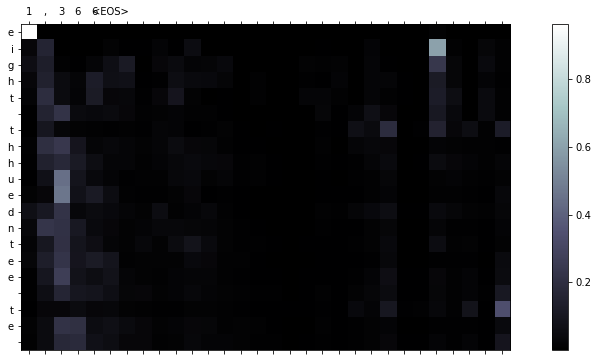

In [141]:
def debug_show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111)
    #cax = ax.matshow(attentions.numpy(), cmap='bone')
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)
    # Set up axes
    #ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    #ax.set_xticklabels([''] + input_sentence + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)
    
    input_sentence = input_sentence + ['<EOS>']
    #inp_arr = ["{}\n{}".format(input_sentence[i], input_sentence[-1-i]) for i in range(len(input_sentence))]
    inp_arr = input_sentence
    ax.set_xticklabels([''] + inp_arr, rotation=0)

    # Show label at every tick
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

    plt.show()
    
def debug_eval_sample_show_attention():
    
    sample_row = balanced_data_sample_row()
    #sample_row = balanced_data[balanced_data['before'].str.len()>15].sample(1).iloc[0]
    sample = sample_row['before'], sample_row['a_word_ind'], sample_row['class'], sample_row['sentence'].split(' ')
    #sample = 'www.google.com', '', '', 'here goes'.split(' ')

    output, decoded_output, decoder_attns_arr, sample = test_model_single_sample(None, 
                                                            return_more=True, sample=sample)
    print('input:  ', sample[0])
    print('output: ', decoded_output)
    print('target: ', sample_row['after'])

    attns = np.array([arr.data[0].cpu().numpy() for arr in decoder_attns_arr])

    debug_show_attention(list(sample[0]), decoded_output, attns)
    #plt.matshow(attns)

debug_eval_sample_show_attention()

In [ ]:
balanced_data.groupby('class')['class'].unique()

In [ ]:
def test_in_categories(iter_len = 1000):
    wrong_preds = {}
    for cat in categories_all:
        tmp_data = sample_data[sample_data['class'] == cat].sample(iter_len)
        correct_n = 0
        wrong_preds_arr = []

        for _ in range(iter_len):
            sample_row = tmp_data.iloc[_]
            sample = sample_row['before'], sample_row['a_word_ind'], sample_row['class'], sample_row['sentence']

            output, t1, sample_target, t2 = test_model_single_sample(None, sample=sample)
            if output == sample_target:
                correct_n += 1
            else:
                wrong_preds_arr.append([sample_target, output])

        print("{:>10}: {:>5d}/{:>5d} ({:>4.0%})".format(cat, correct_n, iter_len, correct_n/iter_len))
        wrong_preds[cat] = wrong_preds_arr
    return wrong_preds

In [ ]:
wrong_preds = test_in_categories(3000)

In [ ]:
wrong_preds['LETTERS']

In [ ]:
# With training longer words
wrong_preds = test_in_categories()